In [1]:
from cowerc_adsorption import (
    PhysicalParams,
    Simulation,
    ExperimentalBreakthroughData,
    plot_btc_and_data,
)

import matplotlib.pyplot as plt
import numpy as np

from math import pi
from pathlib import Path

import pandas as pd

In [2]:
excel_file = Path("../../.data/Data and Column Properties.xlsx")
sheet_name = "WW All Contaminants 0.18-min"

In [3]:
# Read Emma's excel report
xls_setup = pd.read_excel(excel_file, sheet_name=sheet_name, nrows=18, usecols="A:B", index_col=0)
xls_setup

,Value
Design Parameters,
Column Diameter (cm),0.660000
Column Area (cm^2),0.340000
Particle Size (cm),0.016800
Column Diameter/Particle Size Ratio,39.285714
Reynold&apos;s Number,0.270000
Bed Voidage (ε),0.500000
Hydraulic Loading Rate (cm/s),0.080000
EBCT,0.180000
Flow Rate (mL/s),0.028000


In [4]:
xls_influent = pd.read_excel(excel_file, sheet_name=sheet_name, skiprows=11, nrows=4, usecols="D:J")
xls_influent.set_index("Unnamed: 3", inplace=True)
xls_influent

,PFOA,PFHxA,PFHxS,BEZ,DCF,PFBA
Unnamed: 3,,,,,,
Influent 1,185.0,161.50,376,391.00,318.50,160.0
Influent 2,161.0,164.00,347,366.50,355.50,165.5
Influent 3,189.5,179.50,411,334.00,326.00,174.0
Influent AVG,178.5,168.33,378,363.83,333.33,166.5


In [5]:
xls_btc = pd.read_excel(excel_file, sheet_name=sheet_name, header=19, usecols="A:Q")
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFHxA,PFHxA C/C0,PFHxS,PFHxS C/C0,BEZ,BEZ C/C0,DCF,DCF C/C0,PFBA,PFBA C/C0
0,1,30.000000,49.5,170.689655,825.000000,0.50,0.002801,13.70,0.081386,0.00,0.000000,51.25,0.140861,61.30,0.18390,0.00,0.000000
1,2,91.818182,151.5,522.413793,2525.000000,0.00,0.000000,20.50,0.121782,0.00,0.000000,84.00,0.230875,72.45,0.21735,41.35,0.248348
2,3,277.272727,457.5,1577.586207,7625.000000,11.35,0.063585,43.55,0.258713,10.36,0.027407,154.50,0.424645,99.95,0.29985,128.00,0.768769
3,4,775.454545,1279.5,4412.068966,21325.000000,19.15,0.107283,56.10,0.333267,34.05,0.090079,251.50,0.691251,127.50,0.38250,182.00,1.093093
4,5,1274.848485,2103.5,7253.448276,35058.333333,26.80,0.150140,86.75,0.515347,49.80,0.131746,275.00,0.755841,131.15,0.39345,194.50,1.168168
5,6,2325.757576,3837.5,13232.758621,63958.333333,34.25,0.191877,129.00,0.766337,41.75,0.110450,346.00,0.950985,185.50,0.55650,219.50,1.318318
6,7,2882.121212,4755.5,16398.275862,79258.333333,45.60,0.255462,118.50,0.703960,55.05,0.145635,358.50,0.985341,139.00,0.41700,173.00,1.039039
7,9,3403.333333,5615.5,19363.793103,93591.666667,43.75,0.245098,116.00,0.689109,63.00,0.166667,377.00,1.036189,164.00,0.49200,170.50,1.024024
8,10,3924.545455,6475.5,22329.310345,107925.000000,59.25,0.331933,131.00,0.778218,96.60,0.255556,392.50,1.078791,229.00,0.68700,176.50,1.060060
9,12,4966.969697,8195.5,28260.344828,136591.666667,70.05,0.392437,111.00,0.659406,100.05,0.264683,376.00,1.033440,259.00,0.77700,174.50,1.048048


In [6]:
setup = xls_setup.to_dict()["Value"]

In [7]:
porosity = setup["Bed Voidage (ε)"]
lenght = setup["Bed Length (cm)"]

area = 0.25 * pi * setup["Column Diameter (cm)"] ** 2  # cm²
pore_velocity = setup["Flow Rate (mL/min)"] / (area * porosity)  # cm/min

In [8]:
xls_btc

,Sample ID,Time (min.),Cum. Vol.,Bed Vol Passed (BV),Specific Throughput,PFOA,PFOA C/C0,PFHxA,PFHxA C/C0,PFHxS,PFHxS C/C0,BEZ,BEZ C/C0,DCF,DCF C/C0,PFBA,PFBA C/C0
0,1,30.000000,49.5,170.689655,825.000000,0.50,0.002801,13.70,0.081386,0.00,0.000000,51.25,0.140861,61.30,0.18390,0.00,0.000000
1,2,91.818182,151.5,522.413793,2525.000000,0.00,0.000000,20.50,0.121782,0.00,0.000000,84.00,0.230875,72.45,0.21735,41.35,0.248348
2,3,277.272727,457.5,1577.586207,7625.000000,11.35,0.063585,43.55,0.258713,10.36,0.027407,154.50,0.424645,99.95,0.29985,128.00,0.768769
3,4,775.454545,1279.5,4412.068966,21325.000000,19.15,0.107283,56.10,0.333267,34.05,0.090079,251.50,0.691251,127.50,0.38250,182.00,1.093093
4,5,1274.848485,2103.5,7253.448276,35058.333333,26.80,0.150140,86.75,0.515347,49.80,0.131746,275.00,0.755841,131.15,0.39345,194.50,1.168168
5,6,2325.757576,3837.5,13232.758621,63958.333333,34.25,0.191877,129.00,0.766337,41.75,0.110450,346.00,0.950985,185.50,0.55650,219.50,1.318318
6,7,2882.121212,4755.5,16398.275862,79258.333333,45.60,0.255462,118.50,0.703960,55.05,0.145635,358.50,0.985341,139.00,0.41700,173.00,1.039039
7,9,3403.333333,5615.5,19363.793103,93591.666667,43.75,0.245098,116.00,0.689109,63.00,0.166667,377.00,1.036189,164.00,0.49200,170.50,1.024024
8,10,3924.545455,6475.5,22329.310345,107925.000000,59.25,0.331933,131.00,0.778218,96.60,0.255556,392.50,1.078791,229.00,0.68700,176.50,1.060060
9,12,4966.969697,8195.5,28260.344828,136591.666667,70.05,0.392437,111.00,0.659406,100.05,0.264683,376.00,1.033440,259.00,0.77700,174.50,1.048048


In [9]:
contaminants = ["PFBA", "BEZ", "PFHxA", "DCF", "PFOA", "PFHxS"]
c_0 = xls_influent.loc["Influent AVG"][contaminants].to_numpy()
c_0

array([166.5 , 363.83, 168.33, 333.33, 178.5 , 378.  ])

In [10]:
experimental_data = ExperimentalBreakthroughData(
    time=np.round((xls_btc["Time (min.)"] * lenght / pore_velocity), 2).to_numpy(),
    conc=xls_btc[[f"{k} C/C0" for k in contaminants]].to_numpy().T,
    c_0=c_0,
)

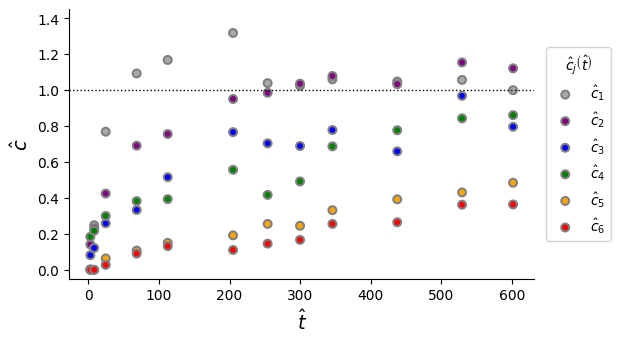

In [11]:
experimental_data.plot_breakthrough()

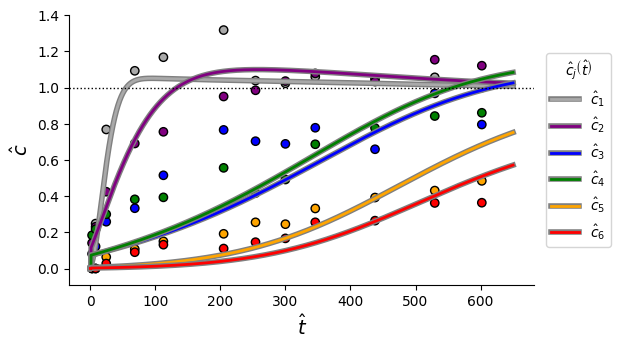

In [12]:
p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=2.6e5,
    k_ads=(50, 25, 30, 30, 60, 70),
    k_des=(2, 0.4, 0.02, 0.025, 0.015, 0.01),
    C_0=c_0,
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()

display(plot_btc_and_data(sim, experimental_data))

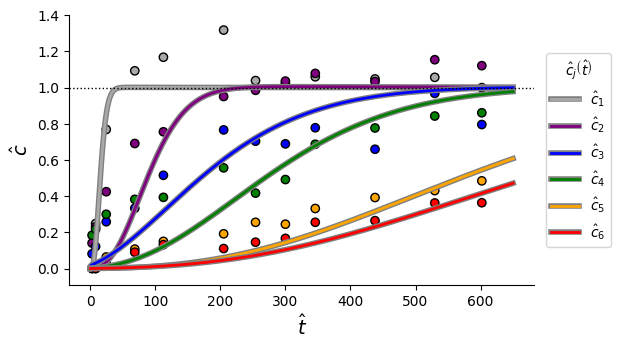

In [23]:
optimal_parameter_set = [
    6.41e06,
    *(9.13e01, 9.41e01, 4.65e01, 7.29e01, 9.67e01, 9.17e01),
    *(5.96e00, 1.01e00, 2.37e-01, 2.45e-01, 1.54e-01, 1.22e-01),
]


p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=optimal_parameter_set[0],
    k_ads=optimal_parameter_set[1:7],
    k_des=optimal_parameter_set[7:],
    C_0=c_0,
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()

display(plot_btc_and_data(sim, experimental_data))

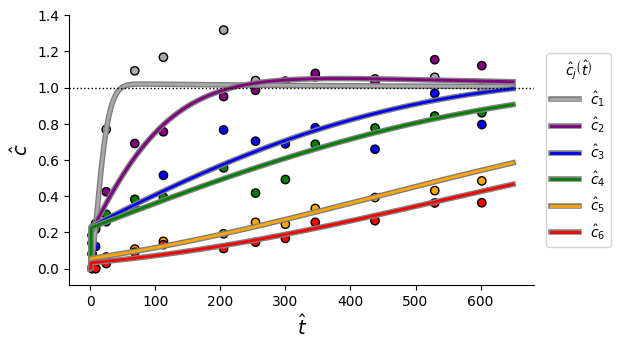

In [38]:
optimal_parameter_set = [
    5.63e00,
    *(1.639e00, 1.267e00, 1.224e00, 1.232e00, 1.522e00, 1.602e00),
    *(4.111e-01, -6.239e-01, -1.350e00, -1.518e00, -1.681e00, -1.726e00),
]

optimal_parameter_set = [10**k for k in optimal_parameter_set]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=optimal_parameter_set[0],
    k_ads=optimal_parameter_set[1:7],
    k_des=optimal_parameter_set[7:],
    C_0=experimental_data.c_0,
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()

display(plot_btc_and_data(sim, experimental_data))

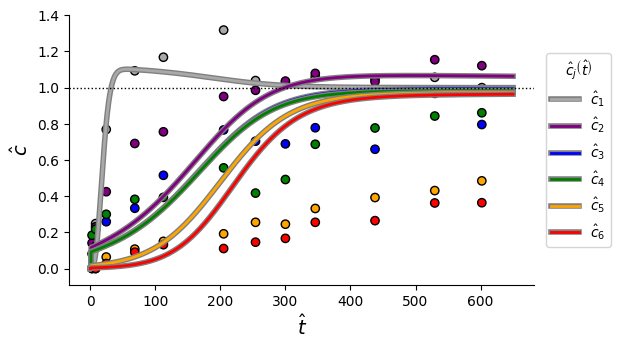

In [49]:
## Addind weigth to the first and second experiment
## Using SCIPY
optimal_parameter_set = [
    12.71e4,
    100.0,
    24.78,
    27.23,
    27.42,
    48.38,
    67.25,
    5.16e00,
    7.80e-03,
    7.62e-04,
    1.00e-05,
    1.00e-05,
    1.00e-05,
]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=optimal_parameter_set[0],
    k_ads=optimal_parameter_set[1:7],
    k_des=optimal_parameter_set[7:],
    C_0=experimental_data.c_0,
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()

display(plot_btc_and_data(sim, experimental_data))

Finished solve() in 0.9340 secs


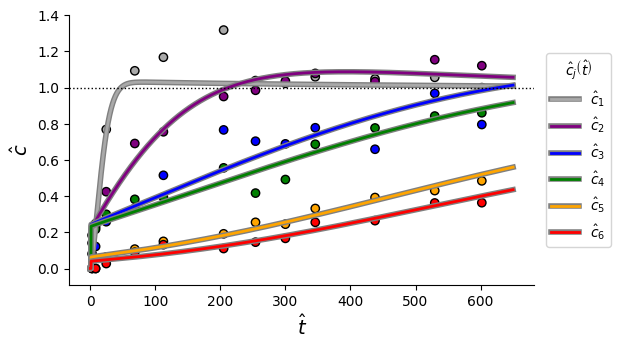

In [16]:
# Running OSTRICH - Adding some weight to the first observations
optimal_parameter_set = [
    3.021131e00,
    1.630375e00,
    1.238411e00,
    1.207940e00,
    1.221111e00,
    1.500632e00,
    1.568869e00,
    3.790512e-01,
    -7.306494e-01,
    -1.602964e00,
    -1.814038e00,
    -2.292577e00,
    -2.626569e00,
]

optimal_parameter_set = [10**x for x in optimal_parameter_set]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=optimal_parameter_set[0],
    k_ads=optimal_parameter_set[1:7],
    k_des=optimal_parameter_set[7:],
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()

display(plot_btc_and_data(sim, experimental_data))

Finished solve() in 0.8620 secs


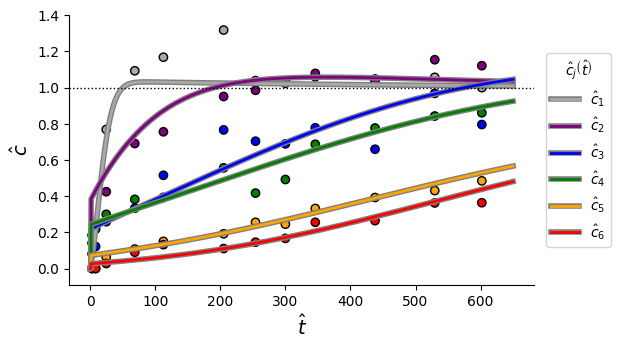

In [17]:
# Running OSTRICH - Longer PSO run
optimal_parameter_set = [
    3.012077e00,
    1.619738e00,
    1.038411e00,  # -3.765052e00,
    1.238604e00,
    1.208159e00,
    1.479917e00,
    1.622559e00,
    3.404749e-01,
    -7.306494e-01,  # -2.886787e00,
    -1.513644e00,
    -1.798898e00,
    -2.319609e00,
    -2.174333e00,
]

optimal_parameter_set = [10**x for x in optimal_parameter_set]

p = PhysicalParams(
    L=lenght,
    v=pore_velocity,
    n=porosity,
    sm=optimal_parameter_set[0],
    k_ads=optimal_parameter_set[1:7],
    k_des=optimal_parameter_set[7:],
)

sim = Simulation(**p.nondim)
sim.end_time = 650
sim.cfl = 0.9
sim.solve()

display(plot_btc_and_data(sim, experimental_data))

In [18]:
# def f(
#     times_to_query,
#     sm,
#     kads_1,
#     kads_2,
#     kads_3,
#     kads_4,
#     kads_5,
#     kads_6,
#     kdes_1,
#     kdes_2,
#     kdes_3,
#     kdes_4,
#     kdes_5,
#     kdes_6,
# ):
#     k_ads = (kads_1, kads_2, kads_3, kads_4, kads_5, kads_6)
#     k_des = (kdes_1, kdes_2, kdes_3, kdes_4, kdes_5, kdes_6)

#     p = PhysicalParams(
#         L=lenght,
#         v=pore_velocity,
#         n=porosity,
#         sm=sm,
#         k_ads=k_ads,
#         k_des=k_des,
#     )

#     sim = Simulation(**p.nondim)
#     sim.end_time = 650
#     sim.cfl = 0.9
#     sim.solve()

#     # Query the btc from t
#     t, btc = sim.btc
#     results = [np.interp(times_to_query, t, c) for c in btc]
#     results = np.array(results)
#     return results.flatten()


In [19]:
# p0 = (
#     500,  # sm
#     *((50,) * 6),  # kads
#     *(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
# )

# print(f(experimental_data.time, *p0))

In [20]:
# ## No bias, all observations are equal
# p0 = (
#     10000,  # sm
#     *((50,) * 6),  # kads
#     *(1.5, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
# )

# bounds = Bounds(
#     lb=[1, *(0.01, 0.01, 0.01, 0.01, 0.01, 0.01), *(0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001)],
#     ub=[50000, *(100, 100, 100, 100, 100, 100), *(10, 10, 10, 10, 10, 10)],
# )

# ydata = experimental_data.conc

# fitting_result = curve_fit(
#     f,
#     xdata=experimental_data.time,
#     ydata=ydata.flatten(),
#     p0=p0,
#     bounds=bounds,
#     method="trf",
#     loss="soft_l1",
#     full_output=True,
# )

In [21]:
# fitting_result[0]

In [22]:
# best_params = fitting_result[0]

# p = PhysicalParams(
#     L=lenght,
#     v=pore_velocity,
#     n=porosity,
#     sm=best_params[0],
#     k_ads=best_params[1:7],
#     k_des=best_params[7:],
# )

# display(p)

# nsim = Simulation(**p.nondim)
# nsim.end_time = 650
# nsim.cfl = 0.9
# nsim.solve()

# fig = nsim.plot_breakthrough()
# ax = fig.axes[0]
# colors = cycle(["darkgrey", "purple", "blue", "green", "orange", "red"])

# for btc, color in zip(experimental_data.conc, colors):
#     ax.scatter(
#         experimental_data.time,
#         btc,
#         c=color,
#         path_effects=[Stroke(linewidth=1, foreground="#000")],
#     )

# ax.set_ylim(bottom=-0.09, top=1.4)
# display(fig)

In [23]:
# ## With bias on certain observed points
# p0 = (
#     100,  # sm
#     *(1,) * 6,  # kads
#     *(1, 0.5, 0.15, 0.10, 0.02, 0.01),  # kdes
# )

# bounds = Bounds(
#     lb=[10, *(0.01,) * 6, *(0.00001,) * 6],
#     ub=[1_000, *(100,) * 6, *(10,) * 6],
# )

# ydata = experimental_data.conc
# sigma = np.ones_like(ydata) * 0.05
# sigma[0, 2:7] = 0.001
# sigma[-1:, -4:] = 0.001

# fitting_result_bias = curve_fit(
#     f,
#     xdata=experimental_data.time,
#     ydata=ydata.flatten(),
#     p0=p0,
#     bounds=bounds,
#     sigma=sigma.flatten(),
#     absolute_sigma=True,
#     method="trf",
#     loss="soft_l1",
#     full_output=True,
# )

In [24]:
# best_params_bias = fitting_result_bias[0]

# p = PhysicalParams(
#     L=lenght,
#     v=pore_velocity,
#     n=porosity,
#     sm=best_params_bias[0],
#     k_ads=best_params_bias[1:7],
#     k_des=best_params_bias[7:],
# )

# display(p)

# nsim = Simulation(**p.nondim)
# nsim.end_time = 650
# nsim.cfl = 0.9
# nsim.solve()

# fig = nsim.plot_breakthrough()
# ax = fig.axes[0]
# colors = cycle(["darkgrey", "purple", "blue", "green", "orange", "red"])

# for btc, color in zip(experimental_data.conc, colors):
#     ax.scatter(
#         experimental_data.time,
#         btc,
#         c=color,
#         path_effects=[Stroke(linewidth=1, foreground="#000")],
#     )

# ax.set_ylim(bottom=-0.09, top=1.4)
# display(fig)